# コードベースは YouTube より

https://www.youtube.com/watch?v=NN0A0Cjo2tQ


In [19]:
import numpy as np
from pulp import *
import matplotlib.pyplot as plt


In [13]:
dir(pulp)

['Counter',
 'FixedElasticSubProblem',
 'FractionElasticSubProblem',
 'Iterable',
 'LpAffineExpression',
 'LpConstraint',
 'LpConstraintVar',
 'LpElement',
 'LpFractionConstraint',
 'LpProblem',
 'LpSolverDefault',
 'LpVariable',
 'OrderedDict',
 'PULP_CBC_CMD',
 '_DICT_TYPE',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'clock',
 'const',
 'json',
 'log',
 'logging',
 'lpDot',
 'lpSum',
 'maketrans',
 'mpslp',
 're',
 'sys',
 'time',
 'value',
 'warnings']

In [40]:
# Job
I = (1, 2, 3, 4)

# Job 内の task
K = (1, 2, 3)
processtime = {
    (1,1): 140, (1,2):  40, (1,3): 80,
    (2,1): 40,  (2,2): 100, (2,3): 60,
    (3,1): 60,  (3,2): 160, (3,3): 40,
    (4,1): 100, (4,2):  80, (4,3): 40,
}
machine = {
    (1,1): 1, (1,2): 2, (1,3): 3,
    (2,1): 1, (2,2): 3, (2,3): 2,
    (3,1): 2, (3,2): 3, (3,3): 1,
    (4,1): 2, (4,2): 1, (4,3): 2,
}
M = 10000
s = {}
x = {}

# model
model = LpProblem(sense = LpMinimize)

# 決定変数
mkspan = LpVariable("mkspan", lowBound=0, upBound=None, cat="Continuous")

for i in I:
    for k in K:
        # 開始時刻
        s[i, k] = LpVariable("s{},{}".format(i,k), lowBound=0, upBound=None, cat="Continuous")

        # 作業 i,k が 作業 j,l よりも先に行われることを示す
        for j in I:
            for l in K:
                if (i != j) & (machine[i,k] == machine[j,l]):
                    x[i, k, j, l] = LpVariable("x{},{},{},{}".format(i,k,j,l), cat="Binary")

# 目的関数
model += mkspan

# Constraints
for i in I:
    for k in K:
        model += mkspan >= s[i,k] + processtime[i,k]
        model += s[i,k] >= 0

    for k in range(1, len(K)):
        model += s[i, k + 1] >= s[i, k] + processtime[i, k]

for i in I:
    for k in K:
        for j in I:
            for l in K:
                if (i != j) & (machine[i,k] == machine[j,l]):
                    model += s[j, l] >= s[i, k] + processtime[i, k] - M * (1 - x[i, k, j, l])
                    model += s[i, k] >= s[j, l] + processtime[j, l] - M * x[i, k, j, l]
                    model += x[i, k, j, l] + x[j, l, i, k,] == 1


In [41]:
# 実行
result = model.solve()
print("status", LpStatus[result])
print("value", value(model.objective))

for i in I:
    for k in K:
        print("Value[s]", s[i, k], value(s[i, k]))

for i in I:
    for k in K:
        for j in I:
            for l in K:
                if (i != j) & (machine[i,k] == machine[j,l]):
                    print("Value[x]", x[i, k, j, l], value(x[i, k, j, l]))


Welcome to the CBC MILP Solver 
Version: 2.10.10 
Build Date: Sep 26 2023 

command line - /usr/local/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/arm64/cbc /tmp/d64c4d2dccc64c5b8228242e55c88b6c-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/d64c4d2dccc64c5b8228242e55c88b6c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 145 COLUMNS
At line 559 RHS
At line 700 BOUNDS
At line 737 ENDATA
Problem MODEL has 140 rows, 49 columns and 340 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 260 - 0.00 seconds
Cgl0004I processed model has 56 rows, 31 columns (18 integer (18 of which binary)) and 148 elements
Cbc0038I Initial state - 12 integers unsatisfied sum - 0.168
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 800 iterations 13
Cbc0038I Solution found of 800
Cbc0038I Relaxing continuous gives 800
Cbc0038I Before mini branch and bound, 6 integers at bound 

[20, 30, 40]


<BarContainer object of 3 artists>

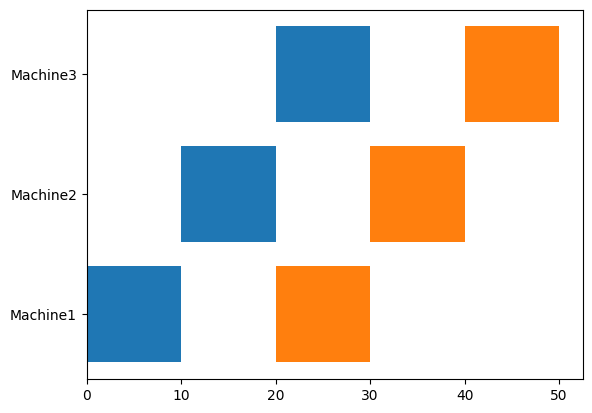

In [27]:
fig, ax = plt.subplots()

# 縦軸の値
machine_name = ["Machine1", "Machine2", "Machine3"]

# 横軸の値
start_time = [0, 10 ,20]
finish_time = [10, 20, 30]
process_time = np.array(finish_time) - np.array(start_time)

ax.barh(machine_name, process_time, left = start_time)

start_time = [20, 30 ,40]
finish_time = [30, 40, 50]
process_time = np.array(finish_time) - np.array(start_time)
print(start_time)

ax.barh(machine_name, process_time, left = start_time)

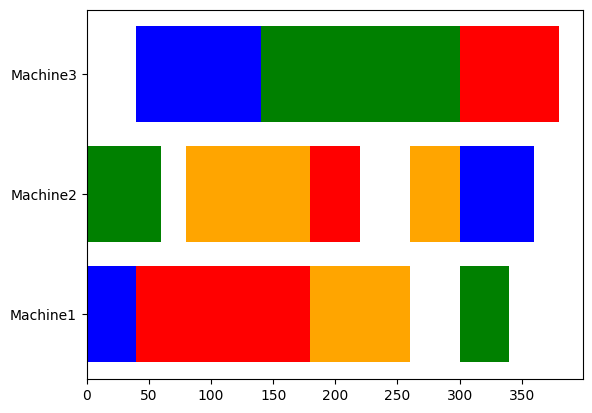

In [42]:
fig, ax = plt.subplots()

# 縦軸の値
machine_name = [
    f"Machine{k}"
    for k in K
]

# 横軸の値
start_time = [0] * len(K)
process_time = [0] * len(K)
# process_time = np.array(finish_time) - np.array(start_time)

for i in I:
    if i == 1: color: str = "red"
    if i == 2: color: str = "blue"
    if i == 3: color: str = "green"
    if i == 4: color: str = "orange"
    for k in K:
        start_time[machine[i, k] - 1] = value(s[i, k])
        process_time[machine[i, k] - 1] = processtime[i, k]

        ax.barh(machine_name, process_time, left = start_time, color=color)
        start_time[machine[i, k] - 1] = 0
        process_time[machine[i, k] - 1] = 0
